# Importation des bibliothèques

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
%load_ext autoreload
%autoreload 2
from modele import Module_lineare
from loss  import MSELoss
import non_lineaire as nl
import numpy as np
import matplotlib.pyplot as plt
import math
import utils as ut

from sklearn.model_selection import train_test_split

# 1. Génération de données aléatoires:

## Avec des données Lineneairement séparables :

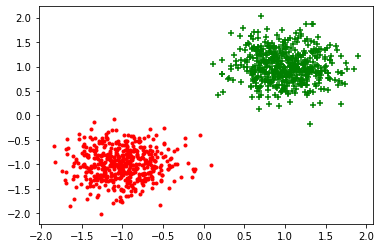

In [229]:
data, y = ut.gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.02)
data, y = ut.gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02)
y = np.where(y==-1,0,1).reshape((-1,1))


ut.plot_data(data,y)

Train : (800, 2)
Test : (200, 2)


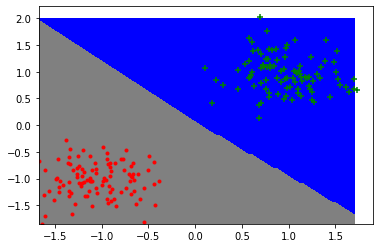

In [236]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)
print('Train :', X_train.shape)
print('Test :', X_test.shape)


module1 = Module_lineare(input_size=2, output_size=3)
activation_tanh = nl.TanH()
module2 = Module_lineare(input_size=3, output_size=1)
activation_sigmoide = nl.Sigmoide()

loss = MSELoss()
learning_rate = 0.01

train_losses = []
test_losses = []
test_accuracies = []
best_params_module1 = None
best_params_module2 = None
loss_min = math.inf

nb_epochs = 1000

for epoch in range(nb_epochs):


    # Forward pass

    # Passe avant (forward pass)
    output1 = module1.forward(X_train)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_train = loss.forward(y_train, output2_activated)
    train_losses.append(np.mean(loss_train))

    # Backward pass
    gradient_loss = loss.backward(y_train, output2_activated)   
    delta_sig = activation_sigmoide.backward_delta(output2, gradient_loss)
    delta_linear_mod1 = module2.backward_delta(output1_activated, delta_sig)
    delta_tanh = activation_tanh.backward_delta(output1, delta_linear_mod1)
    delta_linear_mod1 = module1.backward_delta(X_train, delta_tanh)
    
    # Mise à jour du gradient
    module2.backward_update_gradient(output1_activated, delta_sig)
    module1.backward_update_gradient(X_train, delta_tanh)


    # Mise à jour des paramètres
    module2.update_parameters(learning_rate)
    module1.update_parameters(learning_rate)

    # Test accuracy

    output1 = module1.forward(X_test)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_test = loss.forward(y_test, output2_activated)
    test_losses.append(np.mean(loss_test))

    y_pred = np.where(output2_activated >=0.5, 1, 0)

    accuracy = len(np.where(y_test == y_pred)[0])/len(y_pred)
    # accuracy =  np.where(y_test ==y_pred)[0].mean()
    test_accuracies.append(accuracy)

    module2.zero_grad()
    module1.zero_grad()

    # print(f"Epoch {epoch+1}, Loss: {np.mean(loss_train)}")


def predict(x):
    hidden_l = module1.forward(x)
    hidden_l = activation_tanh.forward(hidden_l)
    hidden_l = module2.forward(hidden_l)
    hidden_l = activation_sigmoide.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

ut.plot_frontiere(X_test, predict, step=100)
ut.plot_data(X_test, y_test.reshape(-1))

### Visualisation de la courbe de loss en fonction des epochs :

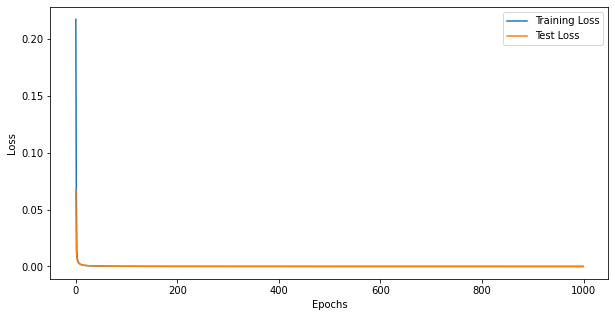

In [237]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualisation de la courbe d'Accuracy en fonction des epochs :

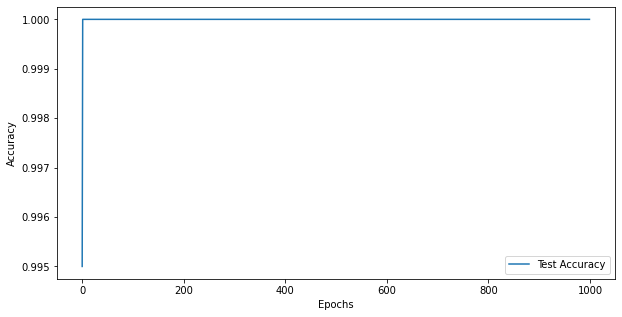

In [238]:
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Avec des données Non separables lineairement:
Ici on utilise des données issues de 4 gaussiennes .

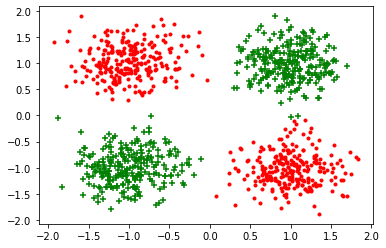

In [ ]:
data, y = ut.gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.01)
y = np.where(y==-1,0,1).reshape((-1,1))


ut.plot_data(data,y)

Train : (800, 2)
Test : (200, 2)
Accuracy :  0.99


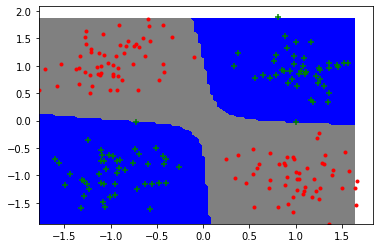

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)
print('Train :', X_train.shape)
print('Test :', X_test.shape)


module1 = Module_lineare(input_size=2, output_size=50,biais=True)
activation_tanh = nl.TanH()
module2 = Module_lineare(input_size=50, output_size=1,biais=True)
activation_sigmoide = nl.Sigmoide()

loss = MSELoss()
learning_rate = 0.0001

train_losses = []
test_losses = []
test_accuracies = []
best_params_module1 = None
best_params_module2 = None
loss_min = math.inf

nb_epochs = 1000

for epoch in range(nb_epochs):

    # Forward pass

    # Passe avant (forward pass)
    output1 = module1.forward(X_train)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_train = loss.forward(y_train, output2_activated)
    train_losses.append(np.mean(loss_train))

    # Backward pass
    gradient_loss = loss.backward(y_train, output2_activated)
    delta_sig = activation_sigmoide.backward_delta(output2, gradient_loss)
    delta_linear_mod1 = module2.backward_delta(output1_activated, delta_sig)
    delta_tanh = activation_tanh.backward_delta(output1, delta_linear_mod1)
    delta_linear_mod1 = module1.backward_delta(X_train, delta_tanh)
    
    # Mise à jour du gradient
    module2.backward_update_gradient(output1_activated, delta_sig)
    module1.backward_update_gradient(X_train, delta_tanh)


    # Mise à jour des paramètres
    module2.update_parameters(learning_rate)
    module1.update_parameters(learning_rate)

    # Test accuracy
    output1 = module1.forward(X_test)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_test = loss.forward(y_test, output2_activated)
    test_losses.append(np.mean(loss_test))

    y_pred = np.where(output2_activated >=0.5, 1, 0)

    accuracy = len(np.where(y_test == y_pred)[0])/len(y_pred)
    # accuracy =  np.where(y_test ==y_pred)[0].mean()
    test_accuracies.append(accuracy)

    module2.zero_grad()
    module1.zero_grad()

    # print(f"Epoch {epoch+1}, Loss: {np.mean(loss_train)}")


def predict(x):
    hidden_l = module1.forward(x)
    hidden_l = activation_tanh.forward(hidden_l)
    hidden_l = module2.forward(hidden_l)
    hidden_l = activation_sigmoide.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

ut.plot_frontiere(X_test, predict, step=100)
ut.plot_data(X_test, y_test.reshape(-1))

y_pred = predict(X_test)
print("Accuracy : ",    len(np.where(y_test == y_pred)[0])/len(y_pred))

Accuracy :  0.997


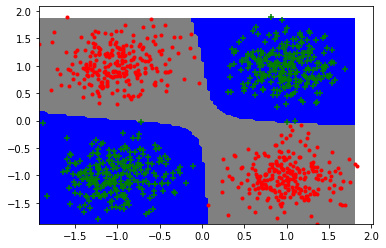

In [25]:
ut.plot_frontiere(data, predict, step=100)
ut.plot_data(data, y.reshape(-1))

y_pred = predict(data)
print("Accuracy : ",    len(np.where(y == y_pred)[0])/len(y_pred))

### Avec Sklearn

/home/djeghali/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy avec skitlearn : 0.995


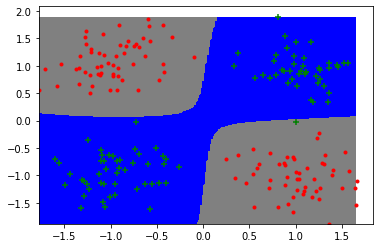

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

model = SVC(kernel='rbf')
model.fit(X_train, y_train)

# Fonction de prédiction
def predict_2(x):
    return model.predict(x)

y_pred = predict_2(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy avec skitlearn :",accuracy)
plt.figure()
ut.plot_frontiere(X_test, predict_2, step=200)
ut.plot_data(X_test, y_test)
plt.show()

Accuracy avec skitlearn : 0.998


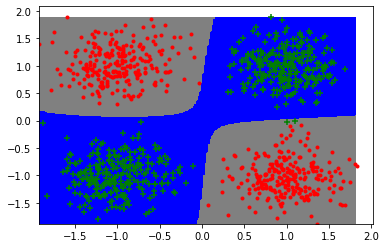

In [22]:

y_pred = predict_2(data)
accuracy = accuracy_score(y, y_pred)

print("Accuracy avec skitlearn :",accuracy)
plt.figure()
ut.plot_frontiere(data, predict_2, step=200)
ut.plot_data(data, y)
plt.show()

### Visualisation de la courbe de loss :

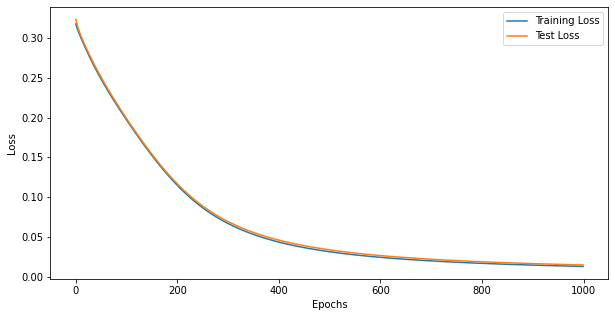

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualisation de la courbe d'Accuracy :

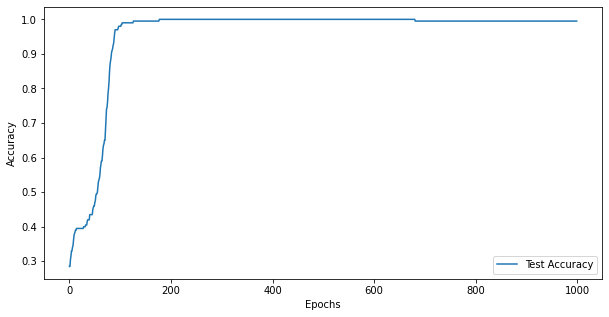

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()